In this case, we had masks created with cellpose. The masks were divided in two types: one type contained individual organelles. The other mask contain the cells (each cell can have up to 6 organelles). In this notebook, we're selecting only the masks with invidual organelles. Sometimes, in other notebooks, we use the cell mask to cut the set of organelles per cell. 

In [1]:
# Import required packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from skimage.measure import label, regionprops, regionprops_table
from scipy.stats import gaussian_kde
import torch
from pathlib import Path
from tqdm import tqdm
import atomai as aoi

In [2]:
# Some helper functions
def make_square(img,box_size):
  y = (box_size - img.shape[0])
  if y%2==0:
    y1=y2=y/2
  else:
    y1 = np.ceil(y/2)
    y2 = y - y1
  x = (box_size - img.shape[1])
  if x%2==0:
    x1=x2=x/2
  else:
    x1 = np.ceil(x/2)
    x2 = x - x1
  
  return np.pad(img,((int(y1),int(y2)),(int(x1),int(x2))),mode='constant',constant_values=0)
  
def normalize_01(inp: np.ndarray):
    """
    normalize image range from 0 to 1
    """
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def rotate_and_pad_img(sample,pixels,box_size,rotate=False):
    """
    Function to crop, rotate, and pad a labelled section of a segmented image
    Args:
      sample (label)
      Sample from labelled image

      pixels (array)
      image array, H x W, single-channel
      
      box_size (int)
      Size of final square image dimension
    Returns square-padded image array
    """
    angle = np.degrees(sample.orientation)
    length = sample.major_axis_length
    width = sample.minor_axis_length
    target_channel = pixels[sample.slice[0].start:sample.slice[0].stop, sample.slice[1].start:sample.slice[1].stop]
    target_channel = (target_channel > 0) * sample.filled_image
    if rotate == True:
      rotated_image = sk.transform.rotate(target_channel, -angle-90, resize = True)
      H, W = rotated_image.shape
      image_center = rotated_image[max([int(H/2-width/2), 0]):int(H/2+width/2)+1,max([0,int(W/2-length/2)]):int(W/2+length/2)]
      return make_square(np.ones(sample.filled_image.shape)*(image_center),box_size)
    else:
      return make_square(np.ones(sample.filled_image.shape)*(target_channel),box_size)

def mask2stack(ccm_mask,cell_mask=None,window_size=115,rotate=False):
  """
  Function to ingest cell mask and carboxysome mask or pixel intensity and output an array of padded submasks
  Args:
  cell_mask (labelled image)
  
  ccm_mask (labelled image or pixel intensity array)

  window_size (int)
  Size of padded image
  """

  if cell_mask.any:
    labelled_image = label(cell_mask)
    feature_table = regionprops(labelled_image)
    CellSize_label = []
        # remove debris
    for i in feature_table:
        if (i.area) > 40 and (i.major_axis_length/i.minor_axis_length) > 2:
                CellSize_label.append(i.label)
    subimgs = []
    for i in np.argsort(CellSize_label):
        sample = feature_table[CellSize_label[i]-1]
        cell = rotate_and_pad_img(sample,cell_mask,window_size,rotate)
        ccm = rotate_and_pad_img(sample,ccm_mask,window_size,rotate)
        #ccm = np.ones(ccm.shape) * (ccm >0.01)
        subimgs.append(ccm)
  else:
    labelled_image = label(ccm_mask)
    feature_table = regionprops(labelled_image)
    subimgs = [make_square(np.ones(sample.filled_image.shape) * sample.filled_image,window_size) for sample in feature_table]
  return np.stack(subimgs,axis=0)

In [3]:
if os.path.exists(r'../data/subimg.npy'):
    subimg = np.load(r'../data/subimg.npy')
else:
    directory = r'../data'
    files = Path(directory).rglob('*.czi')
    mask_stack = list()
    for f in tqdm(list(files)):
        cell_mask = np.load(str(f)[0:-4] + '_cell.npy')
        ccm_mask = np.load(str(f)[0:-4] + '_ccm.npy')
        mask_stack.append(mask2stack(ccm_mask,cell_mask,rotate=False))
    subimg = np.vstack(mask_stack)
    np.save(r'../data/subimg.npy',subimg)
subimg.shape

(62284, 115, 115)

**Plotting some of the subimages**

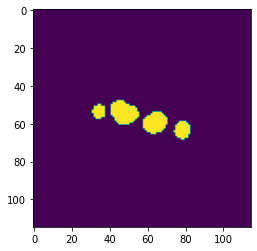

In [16]:
plt.imshow(subimg[4000,:,:])

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='GeForce GTX 1660 Ti', major=7, minor=5, total_memory=6144MB, multi_processor_count=24)

**rVAE**

In [7]:
in_dim = (subimg.shape[1], subimg.shape[2])

#rvae= aoi.models.load_model("cell-rvae-iter200-control-and-induced-4-8-24-48-72.tar")


rvae = aoi.models.rVAE(in_dim, translation= True,
                        numlayers_encoder=3, numhidden_encoder=128,
                        numlayers_decoder=3, numhidden_decoder=128,
                        Skip = True)

rvae.fit(subimg,training_cycles=100, batch_size=10)

Epoch: 1/100, Training loss: 132.1419
Epoch: 2/100, Training loss: 92.4061
Epoch: 3/100, Training loss: 85.4307
Epoch: 4/100, Training loss: 82.9814
Epoch: 5/100, Training loss: 81.5302
Epoch: 6/100, Training loss: 80.5778
Epoch: 7/100, Training loss: 79.7610
Epoch: 8/100, Training loss: 79.2224
Epoch: 9/100, Training loss: 78.7562
Epoch: 10/100, Training loss: 78.3332
Epoch: 11/100, Training loss: 78.0604
Epoch: 12/100, Training loss: 77.7308
Epoch: 13/100, Training loss: 77.4583
Epoch: 14/100, Training loss: 77.1881
Epoch: 15/100, Training loss: 76.9566
Epoch: 16/100, Training loss: 76.7904
Epoch: 17/100, Training loss: 76.5943
Epoch: 18/100, Training loss: 76.4548
Epoch: 19/100, Training loss: 76.3064
Epoch: 20/100, Training loss: 76.1959
Epoch: 21/100, Training loss: 76.0229
Epoch: 22/100, Training loss: 75.9267
Epoch: 23/100, Training loss: 75.8031
Epoch: 24/100, Training loss: 75.7105
Epoch: 25/100, Training loss: 75.6095
Epoch: 26/100, Training loss: 75.5290
Epoch: 27/100, Train

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# cd /content/drive/MyDrive/

In [10]:
# rvae.save_model("cell-rvae-iter100-control-and-induced-4-8-24-48-72")
# rvae.save_weights("cell-w-rvae-iter100-control-and-induced-4-8-24-48-72")

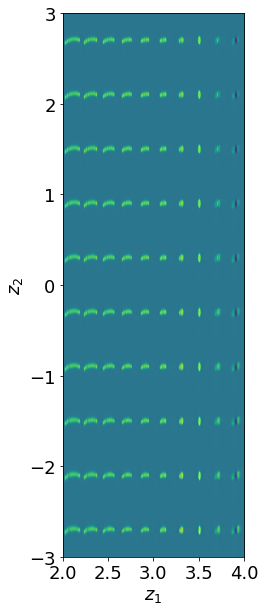

In [11]:
rvae.manifold2d(d=10, l1=[2,4], l2=[-3,3], cmap="viridis");
# rvae.manifold2d(d=24, cmap="viridis");




In [12]:
# rvae.manifold2d(d=5,l1=[-1.5,-1],l2=[-1.5,-1],cmap='viridis');

In [13]:
# rvae.manifold2d(d=5,l1=[0,0.5],l2=[0,0.5],cmap='viridis');

In [14]:
#Control
a4c, b4c = rvae.encode(subimg_1)
a8c, b8c = rvae.encode(subimg_2)
a24c, b24c = rvae.encode(subimg_3)
a48c, b48c = rvae.encode(subimg_4)
a72c, b72c = rvae.encode(subimg_5)
#Induced
a4i, b4i = rvae.encode(subimg_6)
a8i, b8i = rvae.encode(subimg_7)
a24i, b24i = rvae.encode(subimg_8)
a48i, b48i = rvae.encode(subimg_9)
a72i, b72i = rvae.encode(subimg_10)

NameError: name 'subimg_1' is not defined

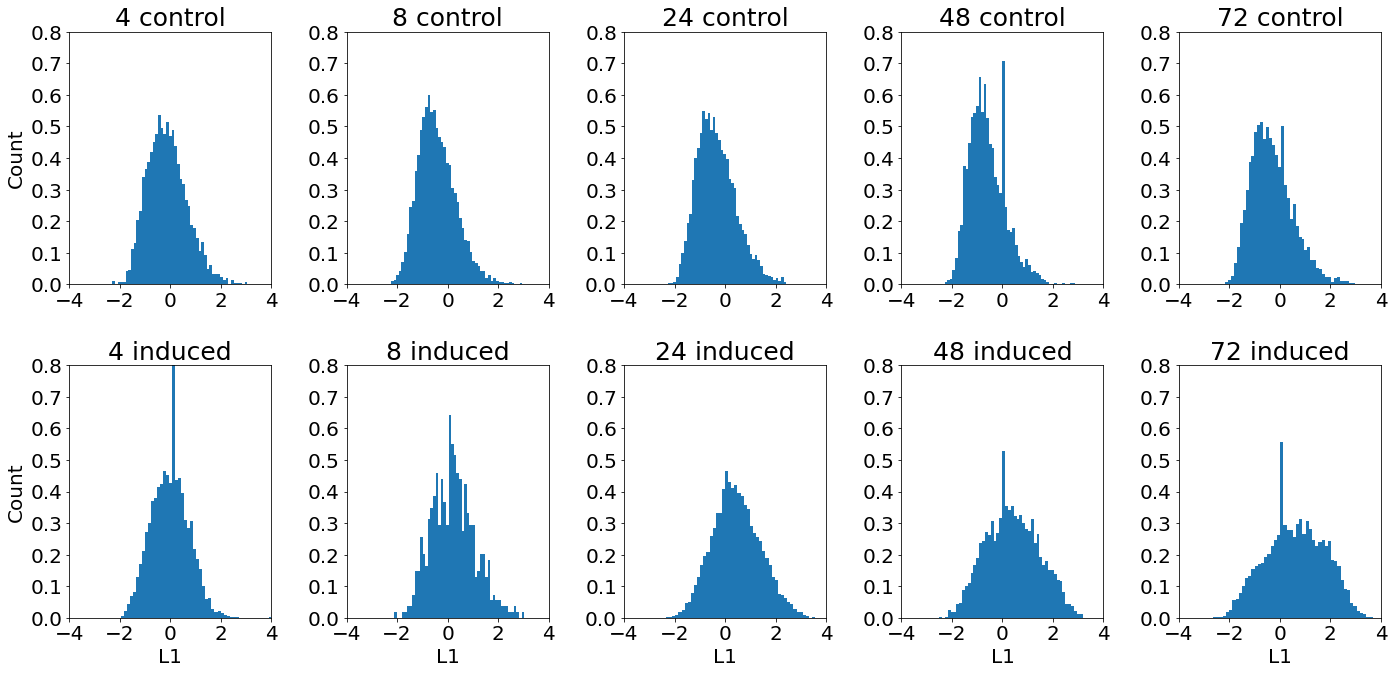

In [ ]:
#L1 histogram
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
ax.set_title('4 control', fontsize=25) 
ax.hist(a4c[:,3], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L1',fontsize=20)
ax.set_ylabel('Count',fontsize=20)
ax.set_xlim([-4, 4])
ax.set_ylim([0, .8])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,2)
ax.set_title('8 control', fontsize=25) 
ax.hist(a8c[:,3], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, .8])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,3)
ax.set_title('24 control',fontsize=25) 
ax.hist(a24c[:,3], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, .8])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,4)
ax.set_title('48 control',fontsize=25) 
ax.hist(a48c[:,3], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, .8])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,5)
ax.set_title('72 control',fontsize=25) 
ax.hist(a72c[:,3], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, .8])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

#Induced
# fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,6)
ax.set_title('4 induced', fontsize=25) 
ax.hist(a4i[:,3], bins = 50, density = True, stacked = True);
ax.set_xlabel('L1',fontsize=20)
ax.set_ylabel('Count',fontsize=20)
ax.set_xlim([-4, 4])
ax.set_ylim([0, .8])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,7)
ax.set_title('8 induced', fontsize=25) 
ax.hist(a8i[:,3], bins = 50, density = True, stacked = True);
ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, .8])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,8)
ax.set_title('24 induced',fontsize=25) 
ax.hist(a24i[:,3], bins = 50, density = True, stacked = True);
ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, .8])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,9)
ax.set_title('48 induced',fontsize=25) 
ax.hist(a48i[:,3], bins = 50, density = True, stacked = True);
ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, .8])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,10)
ax.set_title('72 induced',fontsize=25) 
ax.hist(a72i[:,3], bins = 50, density = True, stacked = True);
ax.set_xlabel('L1',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4,4])
ax.set_ylim([0, 0.8])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

plt.savefig('cell-all-HistogramL1')

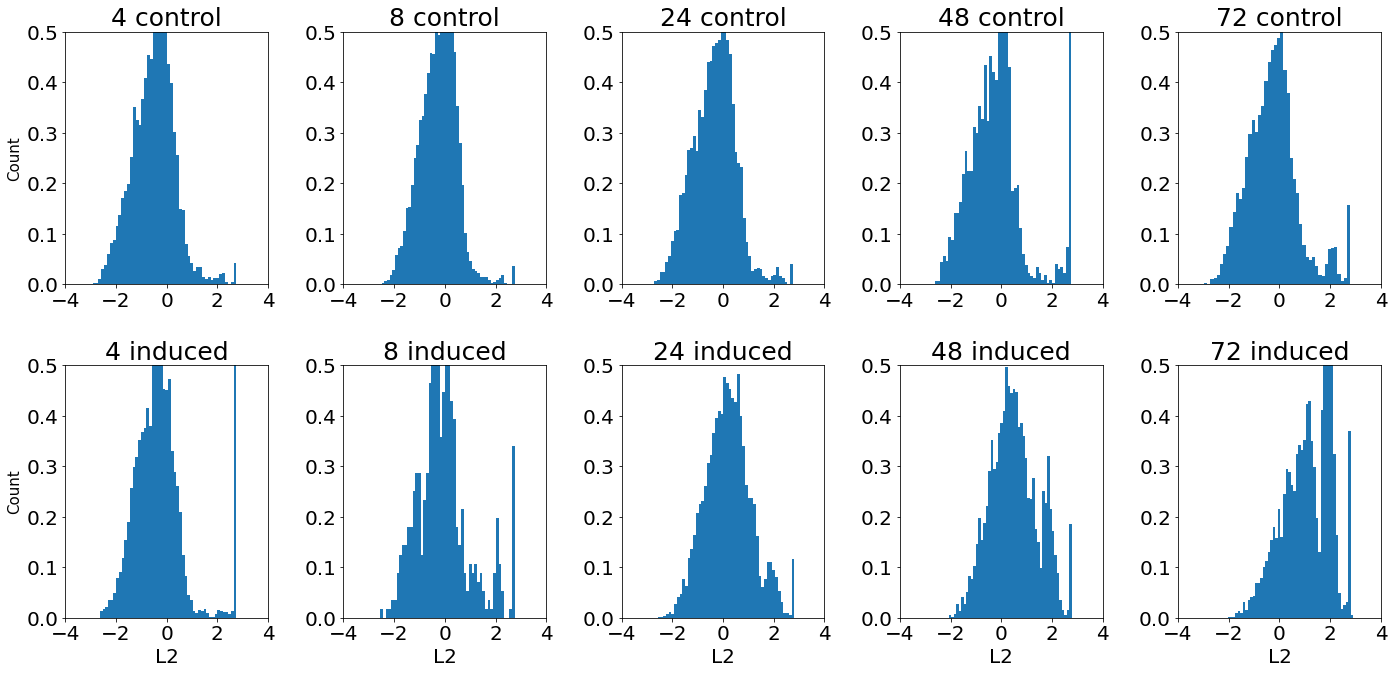

In [ ]:
#Control
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
ax.set_title('4 control',fontsize=25) 
ax.hist(a4c[:,4], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L2',fontsize=20)
ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,2)
ax.set_title('8 control',fontsize=25) 
ax.hist(a8c[:,4], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,3)
ax.set_title('24 control',fontsize=25) 
ax.hist(a24c[:,4], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,4)
ax.set_title('48 control',fontsize=25) 
ax.hist(a48c[:,4], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,5)
ax.set_title('72 control',fontsize=25) 
ax.hist(a72c[:,4], bins = 50, density = True, stacked = True);
# ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

#Induced
# fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,6)
ax.set_title('4 induced',fontsize=25) 
ax.hist(a4i[:,4], bins = 50, density = True, stacked = True);
ax.set_xlabel('L2',fontsize=20)
ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,7)
ax.set_title('8 induced',fontsize=25) 
ax.hist(a8i[:,4], bins = 50, density = True, stacked = True);
ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,8)
ax.set_title('24 induced',fontsize=25) 
ax.hist(a24i[:,4], bins = 50, density = True, stacked = True);
ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,9)
ax.set_title('48 induced',fontsize=25) 
ax.hist(a48i[:,4], bins = 50, density = True, stacked = True);
ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,10)
ax.set_title('72 induced',fontsize=25) 
ax.hist(a72i[:,4], bins = 50, density = True, stacked = True);
ax.set_xlabel('L2',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

plt.savefig('cell-all-HistogramL2')

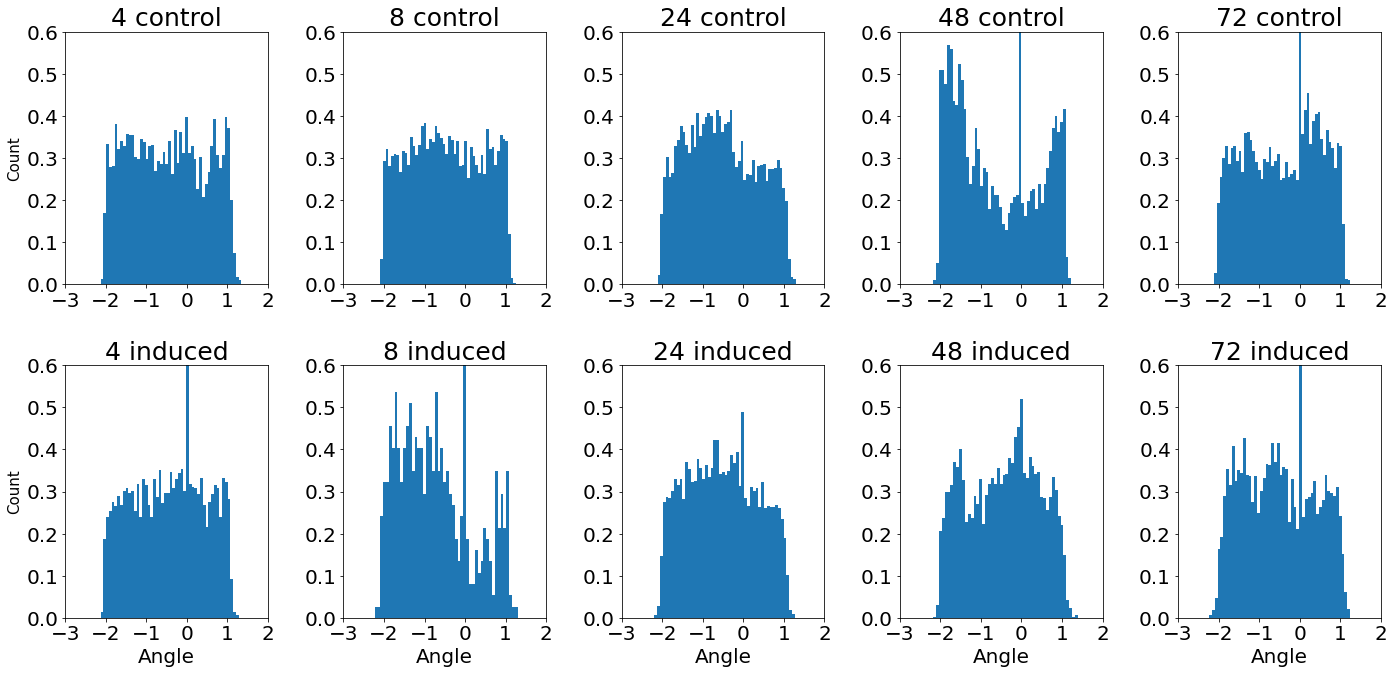

In [ ]:
#Control
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
ax.set_title('4 control',fontsize=25) 
ax.hist(a4c[:,0], bins = 50, density = True, stacked = True);
# ax.set_xlabel('Angle',fontsize=20)
ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,2)
ax.set_title('8 control',fontsize=25) 
ax.hist(a8c[:,0], bins = 50, density = True, stacked = True);
# ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,3)
ax.set_title('24 control',fontsize=25) 
ax.hist(a24c[:,0], bins = 50, density = True, stacked = True);
# ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,4)
ax.set_title('48 control',fontsize=25) 
ax.hist(a48c[:,0], bins = 50, density = True, stacked = True);
# ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,5)
ax.set_title('72 control',fontsize=25) 
ax.hist(a72c[:,0], bins = 50, density = True, stacked = True);
# ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

#Induced
# fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,6)
ax.set_title('4 induced',fontsize=25) 
ax.hist(a4i[:,0], bins = 50, density = True, stacked = True);
ax.set_xlabel('Angle',fontsize=20)
ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,7)
ax.set_title('8 induced',fontsize=25) 
ax.hist(a8i[:,0], bins = 50, density = True, stacked = True);
ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,8)
ax.set_title('24 induced',fontsize=25) 
ax.hist(a24i[:,0], bins = 50, density = True, stacked = True);
ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,9)
ax.set_title('48 induced',fontsize=25) 
ax.hist(a48i[:,0], bins = 50, density = True, stacked = True);
ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,10)
ax.set_title('72 induced',fontsize=25) 
ax.hist(a72i[:,0], bins = 50, density = True, stacked = True);
ax.set_xlabel('Angle',fontsize=20)
# ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([0, 0.6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

plt.savefig('cell-all-HistogramAngle')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is depr

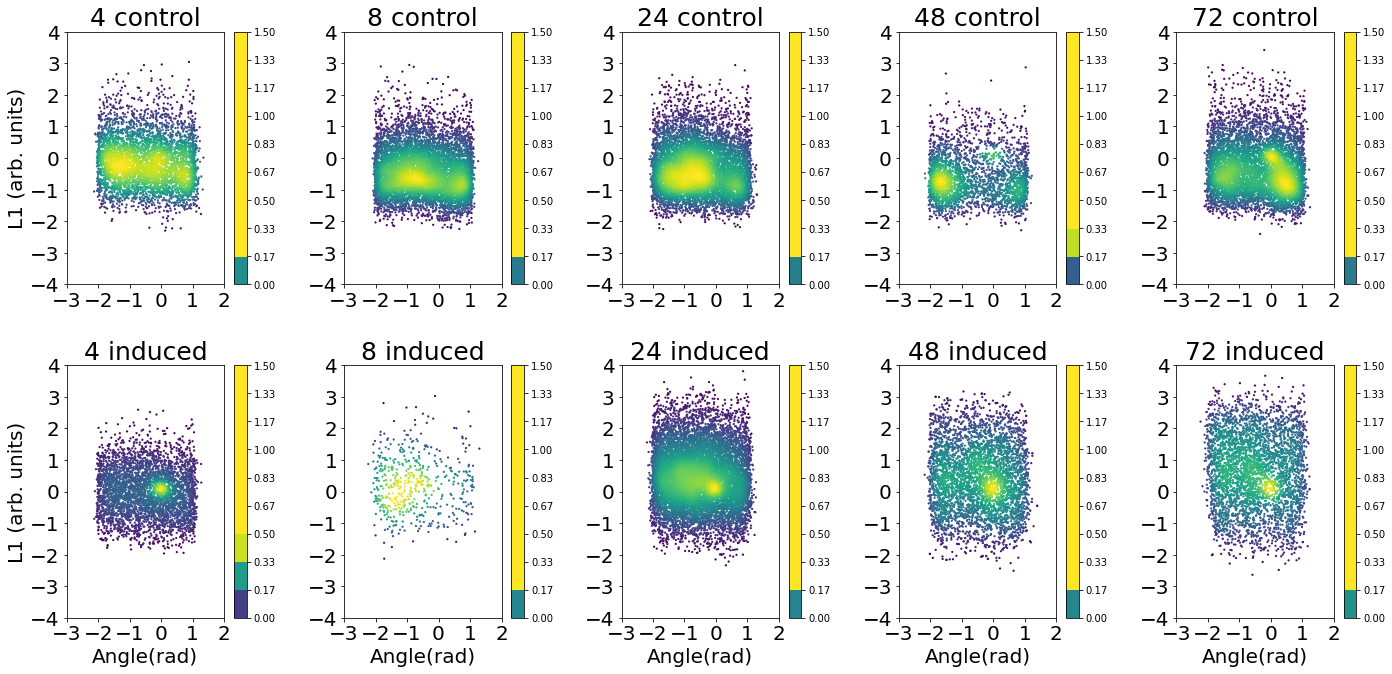

In [ ]:
#Control
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
x = a4c[:,0]
y = a4c[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
ax.set_ylabel('L1 (arb. units)',fontsize=20)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax = fig.add_subplot(2,5,2)
x = a8c[:,0]
y = a8c[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('8 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,3)
x = a24c[:,0]
y = a24c[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('24 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,4)
x = a48c[:,0]
y = a48c[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('48 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,5)
x = a72c[:,0]
y = a72c[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('72 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

#Induced
# fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,6)
x = a4i[:,0]
y = a4i[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
ax.set_ylabel('L1 (arb. units)',fontsize=20)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax = fig.add_subplot(2,5,7)
x = a8i[:,0]
y = a8i[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('8 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,8)
x = a24i[:,0]
y = a24i[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('24 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,9)
x = a48i[:,0]
y = a48i[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('48 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,10)
x = a72i[:,0]
y = a72i[:,3]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('72 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

plt.savefig('cell-all-L1vsAngle')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is depr

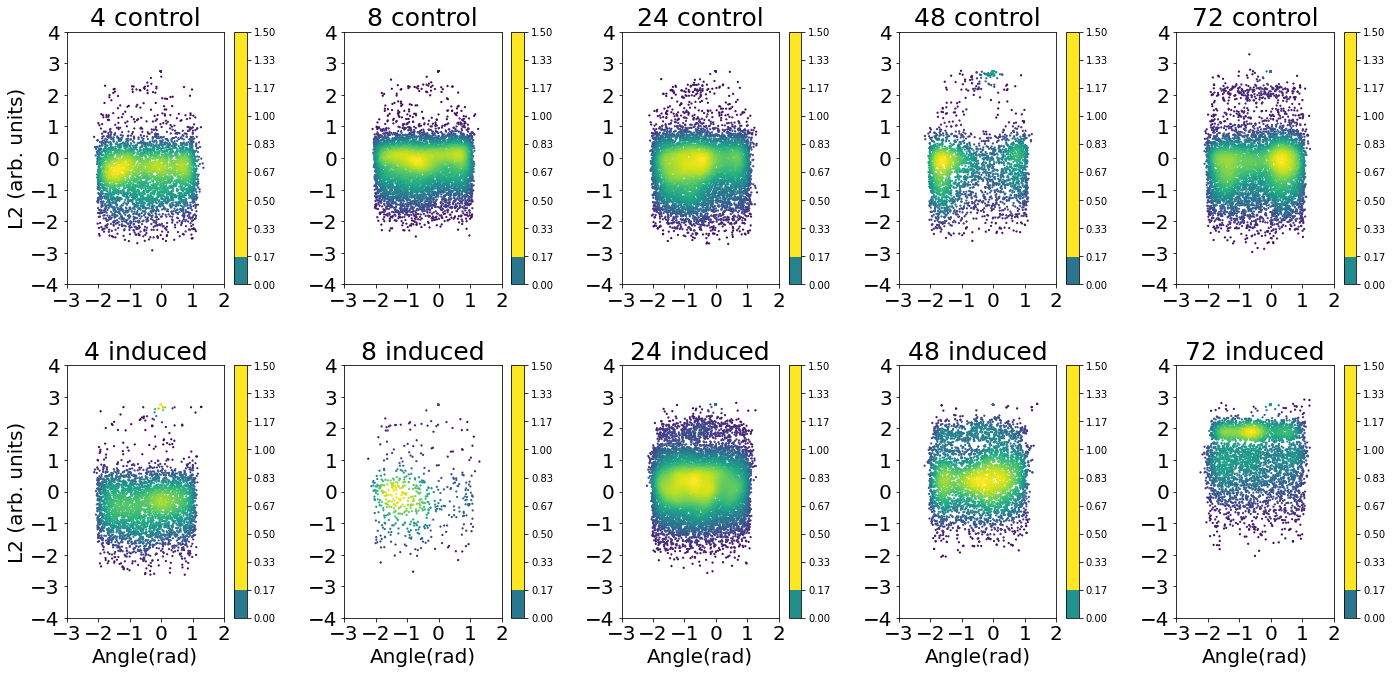

In [ ]:

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
x = a4c[:,0]
y = a4c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
ax.set_ylabel('L2 (arb. units)',fontsize=20)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax = fig.add_subplot(2,5,2)
x = a8c[:,0]
y = a8c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('8 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,3)
x = a24c[:,0]
y = a24c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('24 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,4)
x = a48c[:,0]
y = a48c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('48 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,5)
x = a72c[:,0]
y = a72c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('72 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

#Induced
# fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,6)
x = a4i[:,0]
y = a4i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
ax.set_ylabel('L2 (arb. units)',fontsize=20)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax = fig.add_subplot(2,5,7)
x = a8i[:,0]
y = a8i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('8 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,8)
x = a24i[:,0]
y = a24i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('24 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,9)
x = a48i[:,0]
y = a48i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('48 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,10)
x = a72i[:,0]
y = a72i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('72 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-3, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

plt.savefig('cell-all-L2vsAngle')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is depr

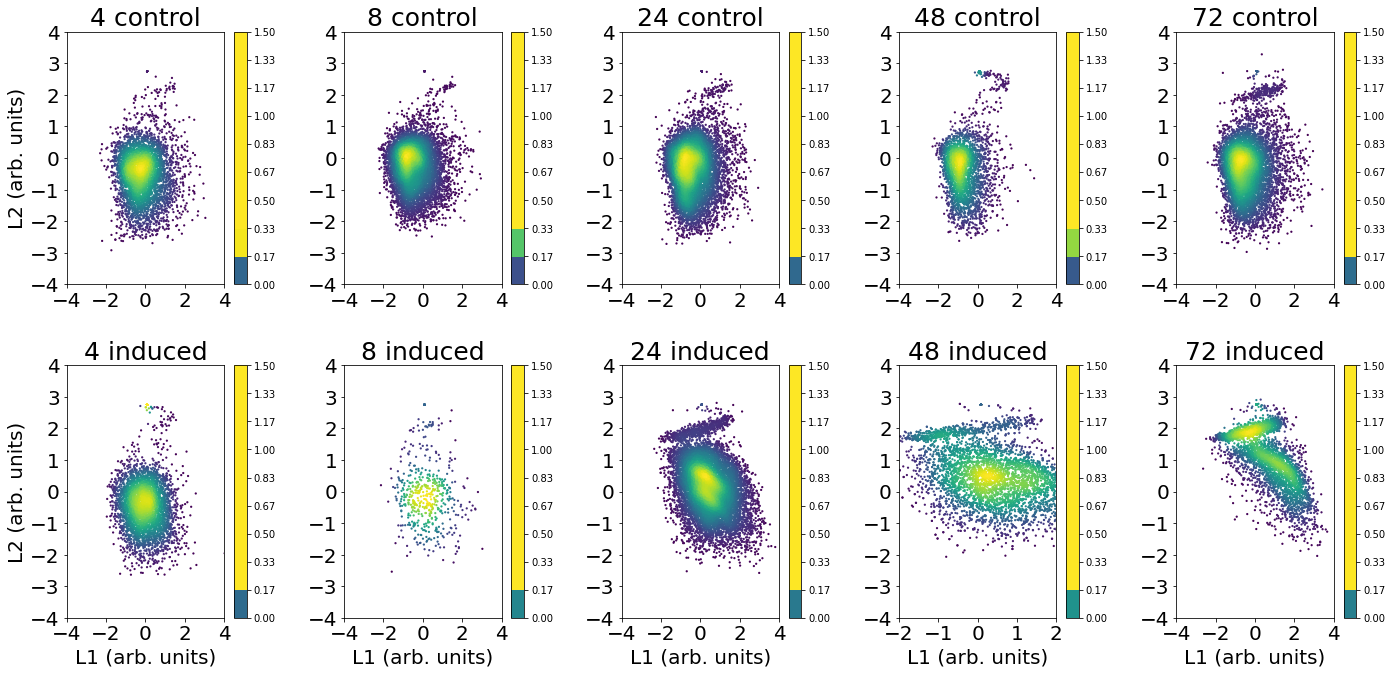

In [ ]:
#Control
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
x = a4c[:,3]
y = a4c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
ax.set_ylabel('L2 (arb. units)',fontsize=20)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax = fig.add_subplot(2,5,2)
x = a8c[:,3]
y = a8c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('8 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,3)
x = a24c[:,3]
y = a24c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('24 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,4)
x = a48c[:,3]
y = a48c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('48 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,5)
x = a72c[:,3]
y = a72c[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('72 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

#Induced
# fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,6)
x = a4i[:,3]
y = a4i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('L1 (arb. units)',fontsize=20)
ax.set_ylabel('L2 (arb. units)',fontsize=20)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax = fig.add_subplot(2,5,7)
x = a8i[:,3]
y = a8i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('8 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('L1 (arb. units)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,8)
x = a24i[:,3]
y = a24i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('24 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('L1 (arb. units)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,9)
x = a48i[:,3]
y = a48i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('48 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('L1 (arb. units)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = fig.add_subplot(2,5,10)
x = a72i[:,3]
y = a72i[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('72 induced',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('L1 (arb. units)',fontsize=20)
# ax.set_ylabel('L1 (arb. units)',fontsize=15)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.tight_layout(pad=3.0)

plt.savefig('cell-all-L2vsL1')

1.7 -2.0
1.7 0.0
1.7 2.0
2.0 -2.0
0.0 1.0
0.0 2.0
0.0 2.5


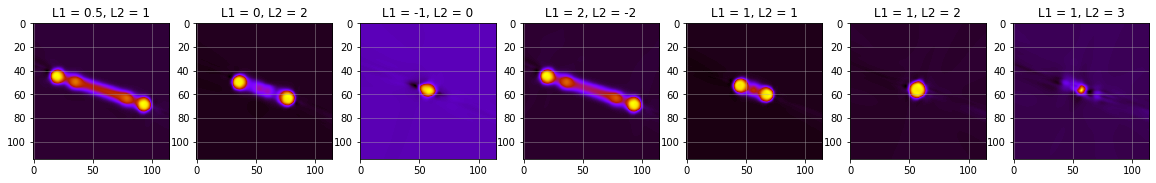

In [ ]:
# L1 = 1.7
# L2 = -2
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded1 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 1.7
# L2 = -1
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -1 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded2 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 1.7
# L2 = 0
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 0 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded3 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 1.7
# L2 = 1
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 1 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded4 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 1.7
# L2 = 1
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 1 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded4 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,7,1)
ax.imshow(decoded1[0], cmap="gnuplot")
ax.set_title('L1 = 0.5, L2 = 1')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,7,2)
ax.imshow(decoded2[0], cmap="gnuplot")
ax.set_title('L1 = 0, L2 = 2')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,7,3)
ax.imshow(decoded3[0], cmap="gnuplot")
ax.set_title('L1 = -1, L2 = 0')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)




0.014559389


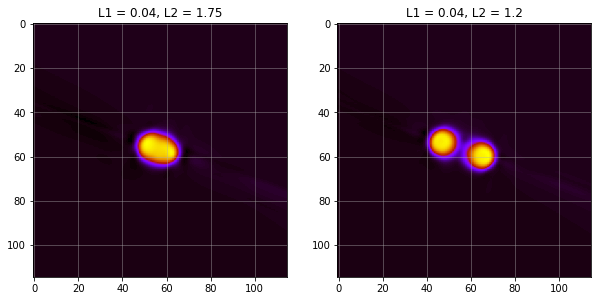

In [ ]:
# L1 = 0
lv1_vals = a72c[:,3][(a72c[:,3] > 0.001) & (a72c[:,3] < 0.05)]

# L2 = 1.75
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 1.75 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded1 = rvae.decode(lv_vals)

# L2 = 1.2
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 1.2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded2 = rvae.decode(lv_vals)
# print("2",lv_vals)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,2,1)
ax.imshow(decoded1[0], cmap="gnuplot")
ax.set_title('L1 = 0.04, L2 = 1.75')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,2,2)
ax.imshow(decoded2[0], cmap="gnuplot")
ax.set_title('L1 = 0.04, L2 = 1.2')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

print(lv1_vals[0])

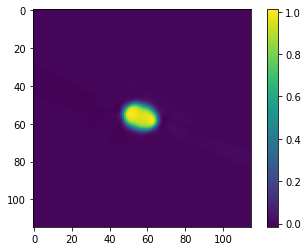

In [ ]:
plt.imshow(decoded1[0])
plt.colorbar()

In [ ]:
atotal, btotal = rvae.encode(subimg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  if __name__ == '__main__':


(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 <a list of 9 Text major ticklabel objects>)

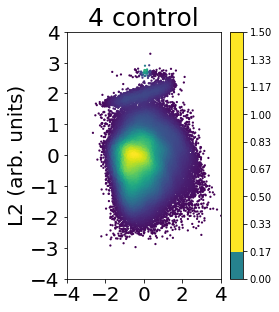

In [ ]:
#Control
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2,5,1)
x = atotal[:,3]
y = atotal[:,4]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.set_title('4 control',fontsize=25) 
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('Angle(rad)',fontsize=20)
ax.set_ylabel('L2 (arb. units)',fontsize=20)
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
# ax.set_clim(0,2)
plt.colorbar(sc,boundaries=np.linspace(0,1.5,10),format='%.2f')
# plt.clim(0,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

5 -0.00022782385 0.0
5 -0.00022782385 0.0
241 -2.0194826 0.0


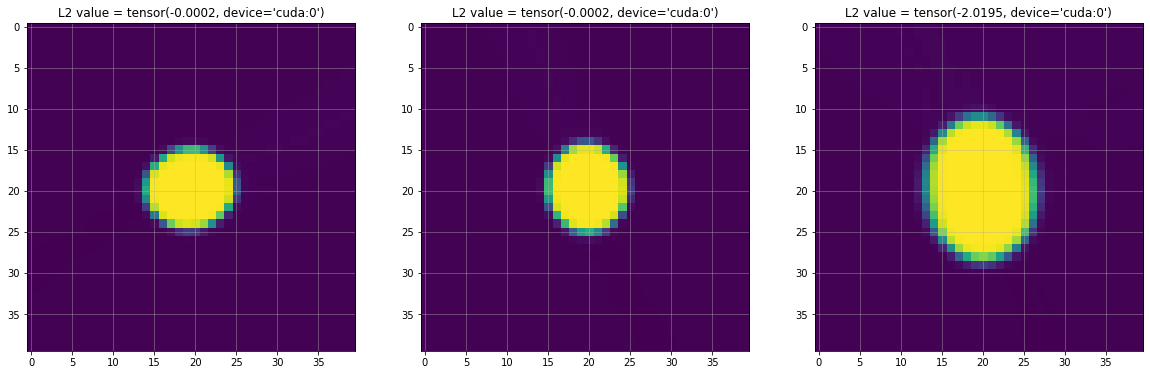

In [ ]:
import torch


#Fixing l1, and varying l2 and the angle
# l2 = 0, angle = -3
alpha = -3  
lv2_vals = a72i[:,4][(a72i[:,4] > -0.001) & (a72i[:,4] < 0)]
lv1_vals = np.zeros_like(lv2_vals) + 0

#Fixing L1 to zero and changing L2 and angle
arr_size = lv2_vals.size
print(arr_size,lv2_vals[0],lv1_vals[0])

device = rvae.device  # to ensure that our arrays are on the same device as model weights
grid = rvae.x_coord.expand(arr_size, *rvae.x_coord.size()).to(device)  # coordinate grid

# angle to rotate (if keeping it constant)
# alpha = -3  
a = (torch.ones(size=(arr_size,)) * alpha).to(device)
l2_1 = torch.from_numpy(lv2_vals).to(device)
l1_1 = torch.from_numpy(lv1_vals).to(device)

# Prepare inputs into the decoder
z = torch.cat((l1_1[:, None], l2_1[:, None]), dim=-1)
grid_ = aoi.utils.transform_coordinates(grid, a, 0)

# Decode
with torch.no_grad():
    decoded1 = rvae.decoder_net(grid_, z).cpu()


# l2 = 0, angle = -1.5
alpha = -1.5
lv2_vals = a72i[:,4][(a72i[:,4] > -0.001) & (a72i[:,4] < 0)]
lv1_vals = np.zeros_like(lv2_vals) + 0

#Fixing L1 to zero and changing L2 and angle
arr_size = lv2_vals.size
print(arr_size,lv2_vals[0],lv1_vals[0])

device = rvae.device  # to ensure that our arrays are on the same device as model weights
grid = rvae.x_coord.expand(arr_size, *rvae.x_coord.size()).to(device)  # coordinate grid

# angle to rotate (if keeping it constant) 
a = (torch.ones(size=(arr_size,)) * alpha).to(device)
l2_2 = torch.from_numpy(lv2_vals).to(device)
l1_2 = torch.from_numpy(lv1_vals).to(device)

# Prepare inputs into the decoder
z = torch.cat((l1_2[:, None], l2_2[:, None]), dim=-1)
grid_ = aoi.utils.transform_coordinates(grid, a, 0)

# Decode
with torch.no_grad():
    decoded2 = rvae.decoder_net(grid_, z).cpu()

# l2 = -2, angle = -1.5
alpha = -1.5  
lv2_vals = a72i[:,4][(a72i[:,4] > -2.1) & (a72i[:,4] < -2)]
lv1_vals = np.zeros_like(lv2_vals) + 0

#Fixing L1 to zero and changing L2 and angle
arr_size = lv2_vals.size
print(arr_size,lv2_vals[0],lv1_vals[0])


device = rvae.device  # to ensure that our arrays are on the same device as model weights
grid = rvae.x_coord.expand(arr_size, *rvae.x_coord.size()).to(device)  # coordinate grid

# angle to rotate (if keeping it constant)
# alpha = -3  
a = (torch.ones(size=(arr_size,)) * alpha).to(device)
l2_3 = torch.from_numpy(lv2_vals).to(device)
l1_3 = torch.from_numpy(lv1_vals).to(device)

# Prepare inputs into the decoder
z = torch.cat((l1_3[:, None], l2_3[:, None]), dim=-1)
grid_ = aoi.utils.transform_coordinates(grid, a, 0)

# Decode
with torch.no_grad():
    decoded3 = rvae.decoder_net(grid_, z).cpu()

fig = plt.figure( figsize=(20, 10))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(decoded1[0])
ax.set_title('L2 value = ' + str(l2_1[0]))
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1, 3, 2)
ax.imshow(decoded2[0])
ax.set_title('L2 value = ' + str(l2_2[0]))
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1, 3, 3)
ax.imshow(decoded3[0])
ax.set_title('L2 value = ' + str(l2_3[0]))
ax.grid(alpha = 0.5)
plt.savefig('angle-decoded-72induced')
